In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

from scipy import signal
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import xgcm
from fsspec.implementations.http import HTTPFileSystem

import cmocean.cm as cmo

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:36802 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 67.27 GB


In [3]:
proj = ccrs.LambertConformal(central_longitude=-92, central_latitude=29)
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='k', facecolor='0.8')

In [4]:
# ds = xr.open_dataset('http://copano.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg_chunk', chunks={'ocean_time':100})

# fs = HTTPFileSystem()
# http_map = fs.get_mapper('http://copano.tamu.edu/zarr/ocean_his_1993.zarr')
# ds = xr.open_zarr(http_map, chunks={'ocean_time':24*3, 's_rho':3}, consolidated=True)

file = './ocean_his_2010.zarr'
ds = xr.open_zarr(file, chunks={'ocean_time':24*3, 's_rho':1}, consolidated=True)

# ds = xr.open_mfdataset('/d2/shared/TXLA_ROMS/output_20yr_obc/2010/ocean_his*.nc', 
#                        combine='nested', concat_dim='ocean_time',
#                        data_vars='minimal', 
#                        coords='minimal',
#                        parallel=True, chunks={'ocean_time':24*3}
#                       )

/opt/miniconda3/lib/python3.7/site-packages/xarray/backends/zarr.py:645: UserWarning: Specified Dask chunks 1 would separate Zarr chunk shape 30 for dimension 's_rho'. This significantly degrades performance. Consider rechunking after loading instead.
  chunk_spec = get_chunk(name, var, chunks)


In [5]:
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})
coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
    'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
    's':{'center':'s_rho', 'outer':'s_w'}}

grid = xgcm.Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w

ds.coords['z_w'] = z_w.transpose()
ds.coords['z_rho'] = z_rho.transpose()

/opt/miniconda3/lib/python3.7/site-packages/dask/array/core.py:3749: PerformanceWarning: Increasing number of chunks by factor of 30
  **blockwise_kwargs
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  del sys.path[0]
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [6]:
t = np.arange(24*3) * 3600.0   # three days, every hour, units seconds
omega_diurnal = 2*np.pi/86400.0
weight = xr.DataArray(np.exp(-1j * omega_diurnal * t), dims=['window'])/len(t)

(-5.637851296924623e-18, -6.091477747390849e-17)

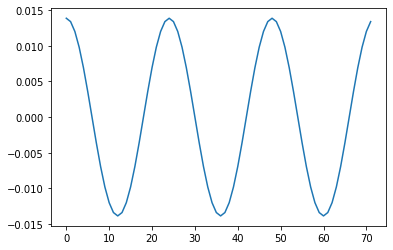

In [7]:
plt.plot(np.real(weight.values))
np.imag(weight.values).sum(), np.real(weight.values).sum()

In [8]:
year = 2010
tstart = '{year:04d}-6-1 00:00'.format(year=year)
tend = '{year:04d}-8-1 00:00'.format(year=year)
timeslice = slice(tstart, tend)

u = ds.u.sel(ocean_time=timeslice).isel(s_rho=-1)
v = ds.v.sel(ocean_time=timeslice).isel(s_rho=-1)

In [9]:
Xu = u.rolling(ocean_time=len(t), center=True).construct('window').dot(weight)
Xv = v.rolling(ocean_time=len(t), center=True).construct('window').dot(weight)

/opt/miniconda3/lib/python3.7/site-packages/xarray/core/computation.py:1180: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return result.transpose(*[d for d in all_dims if d in result.dims])


In [10]:
Au = 2.0*np.abs(Xu).mean(dim='ocean_time').values
Av = 2.0*np.abs(Xv).mean(dim='ocean_time').values

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 5400 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 5402 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 5392 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 5404 was killed by signal 15
distributed.nanny - WARNING - Worker process 5394 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distribute

In [ ]:
# Compute the average phase
# Pu = np.angle(Xu.mean(dim='ocean_time'))
# Pv = np.angle(Xv.mean(dim='ocean_time'))

Pu = np.angle(Xu)
Pv = np.angle(Xv)

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection=proj)
pc = ax.pcolormesh(ds.lon_u.values, ds.lat_u.values, np.angle(Xu[100]), 
                   vmin=-np.pi, vmax=np.pi,
                   cmap=cmo.phase, transform=ccrs.PlateCarree())
ax.add_feature(coast_10m)
plt.colorbar(pc)
ax.set_extent([-98, -88, 25, 30], ccrs.PlateCarree())

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection=proj)
pc = ax.pcolormesh(ds.lon_u.values, ds.lat_u.values, Au, 
#                    norm=colors.LogNorm(vmin=1, vmax=5000),
                   vmin=0, vmax=.30,
                   cmap=plt.cm.Reds, transform=ccrs.PlateCarree())
ax.add_feature(coast_10m)
plt.colorbar(pc, extend='max')
ax.set_extent([-98, -88, 25, 30], ccrs.PlateCarree())

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection=proj)
pc = ax.pcolormesh(ds.lon_v.values, ds.lat_v.values, Av, 
#                    norm=colors.LogNorm(vmin=1, vmax=5000),
                   vmin=0, vmax=.30,
                   cmap=plt.cm.Reds, transform=ccrs.PlateCarree())
ax.add_feature(coast_10m)
plt.colorbar(pc, extend='max')
ax.set_extent([-98, -88, 25, 30], ccrs.PlateCarree())

In [ ]:
foo = 2*np.abs(Xu[1000]).values

In [ ]:
foo = np.ma.masked_where(np.isnan(foo), foo)

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection=proj)
pc = ax.pcolormesh(ds.lon_u.values, ds.lat_u.values, foo, 
                   vmin=0, vmax=0.3,
                   cmap=plt.cm.Reds, transform=ccrs.PlateCarree())
ax.add_feature(coast_10m)
plt.colorbar(pc, extend='max')
ax.set_extent([-98, -88, 25, 30], ccrs.PlateCarree())

### Google earth overlay

In [11]:
kml_groundoverlay = '''<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://earth.google.com/kml/2.0">
<Document>
<GroundOverlay>
  <name>__NAME__</name>
  <color>__COLOR__</color>
  <visibility>__VISIBILITY__</visibility>
  <Icon>
    <href>overlay.png</href>
  </Icon>
  <LatLonBox>
    <south>__SOUTH__</south>
    <north>__NORTH__</north>
    <west>__WEST__</west>
    <east>__EAST__</east>
  </LatLonBox>
</GroundOverlay>
<ScreenOverlay>
    <name>Legend</name>
    <Icon>
        <href>legend.png</href>
    </Icon>
    <overlayXY x="0" y="0" xunits="fraction" yunits="fraction"/>
    <screenXY x="0.015" y="0.075" xunits="fraction" yunits="fraction"/>
    <rotationXY x="0.5" y="0.5" xunits="fraction" yunits="fraction"/>
    <size x="0" y="0" xunits="pixels" yunits="pixels"/>
</ScreenOverlay>
</Document>
</kml>
'''

In [29]:
import zipfile
import os

def geo_pcolor(lon, lat, prop, **kwargs):
    """docstring for geo_pcolor"""
    
    name = kwargs.pop('name', 'overlay')
    color = kwargs.pop('color', '9effffff')
    visibility = str( kwargs.pop('visibility', 1) )
    kmzfile = kwargs.pop('kmzfile', 'overlay.kmz')
    pixels = kwargs.pop('pixels', 1024)  # pixels of the max. dimension
    units = kwargs.pop('units', '')
    vmax = kwargs.pop('vmax', prop.max())
    kwargs['vmax'] = vmax
    vmin = kwargs.pop('vmin', prop.min())
    kwargs['vmin'] = vmin
    
    geo_aspect = np.cos(lat.mean()*np.pi/180.0)
    xsize = lon.ptp()*geo_aspect
    ysize = lat.ptp()
    
    aspect = ysize/xsize
    if aspect > 1.0:
        figsize = (10.0/aspect, 10.0)
    else:
        figsize = (10.0, 10.0*aspect)
    
    fig = plt.figure(figsize=figsize, facecolor=None, frameon=False, dpi=pixels//10)
    ax = fig.add_axes([0, 0, 1, 1])
    pc = ax.pcolor(lon, lat, prop, **kwargs)
    ax.set_xlim(lon.min(), lon.max())
    ax.set_ylim(lat.min(), lat.max())
    ax.set_axis_off()
    plt.savefig('overlay.png')
    
    f = zipfile.ZipFile(kmzfile, 'w')
    f.writestr('overlay.kml', kml_groundoverlay.replace('__NAME__', name)\
                                               .replace('__COLOR__', color)\
                                               .replace('__VISIBILITY__', visibility)\
                                               .replace('__SOUTH__', str(lat.min()))\
                                               .replace('__NORTH__', str(lat.max()))\
                                               .replace('__EAST__', str(lon.max()))\
                                               .replace('__WEST__', str(lon.min())))
    f.write('overlay.png')
    os.remove('overlay.png')
    
    fig = plt.figure(figsize=(1.0, 4.0), facecolor=None, frameon=False)
    ax = fig.add_axes([0.0, 0.05, 0.2, 0.9])
    cb = plt.colorbar(pc, cax=ax)
    cb.set_label(units, color='0.9')
    for lab in cb.ax.get_yticklabels():
        plt.setp(lab, 'color', '0.9')
    
    plt.savefig('legend.png')
    f.write('legend.png')
    os.remove('legend.png')    
    f.close()

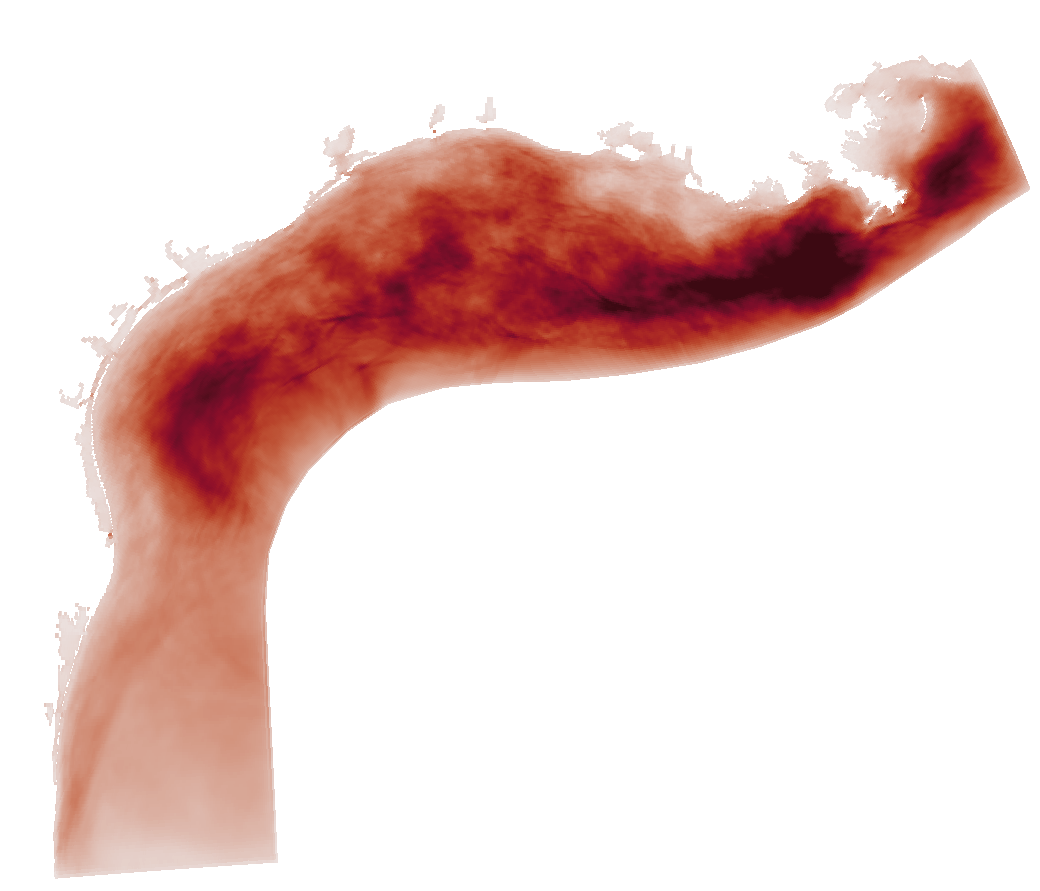

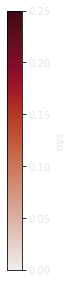

In [37]:
geo_pcolor(ds.lon_u.values, ds.lat_u.values, Au, 
           name='IW u speed, June-July 2010', units='m/s', 
           kmzfile='IWu-JJ.kmz',
           vmin=0, vmax=.25, cmap=cmo.amp)

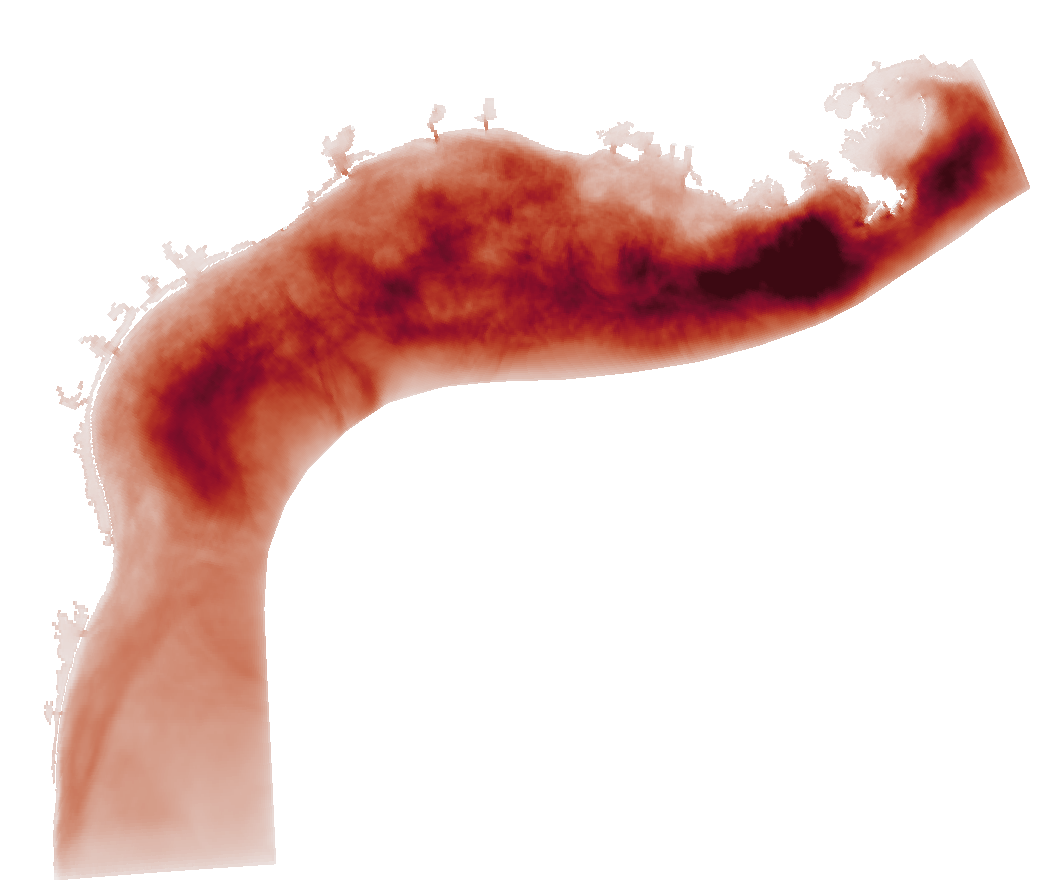

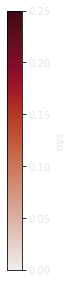

In [38]:
geo_pcolor(ds.lon_v.values, ds.lat_v.values, Av, 
           name='IW u speed, June-July 2010', units='m/s', 
           kmzfile='IWv-JJ.kmz',
           vmin=0, vmax=.25, cmap=cmo.amp)